In [1]:
from simtk import openmm, unit
from simtk.openmm import app
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import torch

device = "cuda:3" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

ctx = torch.zeros([], device=device, dtype=dtype)

In [ ]:
fname = 'cis_pro_1000K_long'

In [4]:
cis_1000K_traj = md.load(f'proline/Trajectories/cis_pro_1000K_long.dcd', top='proline/cis_pro.pdb')
trans_1000K_traj = md.load(f'proline/Trajectories/trans_pro_1000K_long.dcd', top='proline/cis_pro.pdb')
cis_300K_noconstr_traj = md.load(f'proline/Trajectories/cis_pro_300K_noconstr_long.dcd', top='proline/cis_pro.pdb')
trans_300K_noconstr_traj = md.load(f'proline/Trajectories/trans_pro_300K_noconstr_long.dcd', top='proline/cis_pro.pdb')

In [5]:
coupled_traj = md.load('Coupled_scheme/Trajectories/coupled_pro_300K_long.dcd', top='proline/cis_pro.pdb')
coupled_traj_longMD = md.load('Coupled_scheme/Trajectories/coupled_pro_300K_100psMD.dcd', top='proline/cis_pro.pdb')
coupled_traj_1000K = md.load('Coupled_scheme/Trajectories/coupled_pro_1000K_100psMD.dcd', top='proline/cis_pro.pdb')
MD_1000K = md.load('proline/Trajectories/joined_pro_1000K.dcd', top='proline/cis_pro.pdb')
MD_1000K_noconstr = md.load('proline/Trajectories/pro_1000K_noconstr.dcd', top='proline/cis_pro.pdb')
MD_1000K_noconstr_stride10 = md.load('proline/Trajectories/pro_1000K_noconstr.dcd', top='proline/cis_pro.pdb', stride=10)

#coupled_traj_short = md.load('Coupled_scheme/Trajectories/coupled_pro_300K.dcd', top='proline/cis_pro.pdb')

In [6]:
def compute_phi_psi(trajectory):
    phi_atoms = [4,6,7,9]
    phi = md.compute_dihedrals(trajectory, indices=[phi_atoms])[:, 0]
    psi_atoms = [6,7,9,24]
    psi = md.compute_dihedrals(trajectory, indices=[psi_atoms])[:, 0]
    return phi, psi

In [7]:
# import pickle

# try:
#     pickleFile = open(f'parameters/parameters{fname}.pkl','rb')
#     parametersdict = pickle.load(pickleFile)
#     temperature = parametersdict['Temperature']
#     collision_rate = parametersdict['Collision rate']
#     timestep = parametersdict['Timestep']
#     reportInterval = parametersdict['Report Interval']
# except:
#     if '1000' in fname:
#         temperature = 300.0 * unit.kelvin
#         collision_rate = 1.0 / unit.picosecond
#         timestep = 1.0 * unit.femtosecond
#         reportInterval = 'N/A'
#     else:
#         temperature = 300.0 * unit.kelvin
#         collision_rate = 1.0 / unit.picosecond
#         timestep = 2.0 * unit.femtosecond
#         reportInterval = 'N/A'


NameError: name 'fname' is not defined

In [9]:
def plot_phi_psi(ax, trajectory, fname, label):
    # with open('parameterfile.txt') as f:
    #     parameters = f.read()
    import pickle
    try:
        pickleFile = open(f'parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
        reportInterval = parametersdict['Report Interval']
    except:
        if '1000' in fname:
            temperature = 1000.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 1.0 * unit.femtosecond
            reportInterval = 'N/A'
        else:
            temperature = 300.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond
            reportInterval = 'N/A'
    
    parameters = f'{temperature}\nCollision rate:{collision_rate}\nTimestep: {timestep}\nReport every {reportInterval} steps'
    try:
        time = trajectory.n_frames*reportInterval*timestep
    except:
        time = 'N/A'
    phi, psi = compute_phi_psi(trajectory)
    
    ax.hist2d(phi, psi, 50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_title(f'{label}')
    try:
        ax.set_xlabel(f"$\phi$") #\n{parameters}\nTime: {time.value_in_unit(unit.seconds):.3E} s")
    except:
        ax.set_xlabel(f"$\phi$ \n{parameters}\nTime: {time} s")
    _ = ax.set_ylabel("$\psi$")

In [22]:
def plot_energy(ax, trajectory, fname):
    with open('proline/noconstraints_xmlsystem.txt') as f:
        xml = f.read()
    system = openmm.XmlSerializer.deserialize(xml)

    from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
    from openmmtools import integrators
    from simtk import unit
    import pickle

    try:
        pickleFile = open(f'proline/parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
        reportInterval = parametersdict['Report Interval']
    except:
        if '1000' in fname:
            temperature = 1000.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 1.0 * unit.femtosecond
            reportInterval = 'N/A'
        else:
            temperature = 300.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 2.0 * unit.femtosecond
            reportInterval = 'N/A'
    
    integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

    energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
    target_energy = OpenMMEnergy(78, energy_bridge)

    coordinates = trajectory.xyz[0:10000]
    data = torch.tensor(coordinates.reshape(-1,78)).to(ctx)
    sample_energies = target_energy.energy(data).cpu().detach().numpy()
    #md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    if np.percentile(sample_energies, 90) < 100:
        ax2.hist(sample_energies, bins=40, density=False, label="BG")
    else:
        cut = max(np.percentile(sample_energies, 90), 100)
        ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    #ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    plt.axvline(sample_energies.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(sample_energies.mean()*1.1, max_ylim*0.9, f'Mean: {sample_energies.mean():.2f}')
    ax2.set_ylabel(f"Count   [#Samples / {len(coordinates)}]")
    #ax2.legend()

In [ ]:
# import pickle
# pickleFile = open('parameters.pkl','rb')
# parametersdict = pickle.load(pickleFile)
    
# time = traj.n_frames*parametersdict['Report Interval']*parametersdict['Timestep']
# print(time.value_in_unit(unit.seconds))
# print(time)

In [11]:
def plot_omega(ax, trajectory, label, y_label=True):
    omega_atoms = [0,4,6,7]
    omega = md.compute_dihedrals(trajectory, indices=[omega_atoms])[:, 0]
    binwidth = 0.05
    bins = np.arange(-np.pi, np.pi + binwidth ,binwidth)
    ax.hist(omega, bins=bins)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xlabel(f"$\omega$")
    ax.set_title(f'{label}')
    if y_label==True:
        ax.set_ylabel(f"Count   [#Samples / {len(omega)}]")

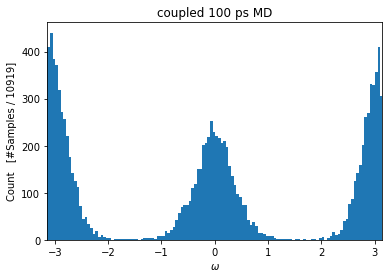

In [12]:
fig,ax = plt.subplots()

plot_omega(ax,coupled_traj_1000K,'coupled 100 ps MD')

In [13]:
state = 'cis'
transition_counter = 0
for frame in coupled_traj_1000K:
    omega_atoms = [0,4,6,7]
    omega = md.compute_dihedrals(frame, indices=[omega_atoms])[:, 0]

    if state == 'cis' and np.abs(omega) > 1.5:
        transition_counter += 1
        state = 'trans'
    elif state == 'trans' and np.abs(omega) < 1.5:
        transition_counter += 1
        state = 'cis'

print(transition_counter)


997


In [14]:
#counts percentage - currently for last quarter of trajectory

trans_count = 0
cis_count = 0

for frame in MD_1000K_noconstr[round(len(MD_1000K_noconstr)*0.75):round(len(MD_1000K_noconstr)*1)]:
    omega_atoms = [0,4,6,7]
    omega = md.compute_dihedrals(frame, indices=[omega_atoms])[:, 0]

    if np.abs(omega) > 1.57:
        trans_count += 1

    elif np.abs(omega) < 1.57:
        cis_count += 1

    else: 
        print('omega not found')

print('cis', cis_count/(cis_count+trans_count)*100)
print('trans', trans_count/(cis_count+trans_count)*100)


cis 35.931999999999995
trans 64.068


In [ ]:
print(np.average([31.36,26.92,31.18,35.93]))
print(np.std([31.36,26.92,31.18,35.93]))

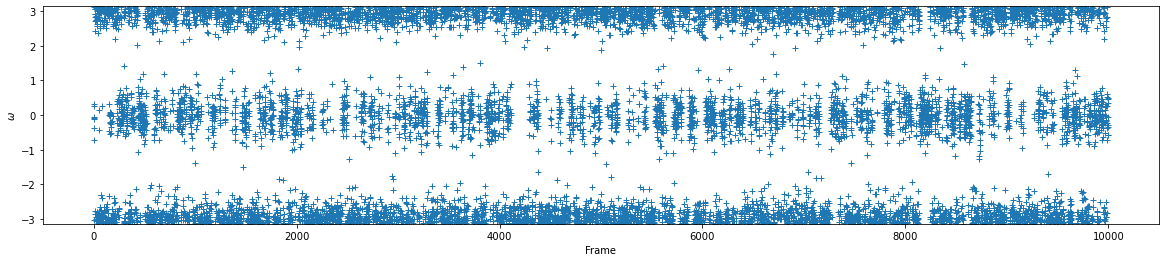

In [15]:
#plots omega over frames of trajectory. 

fig, ax = plt.subplots(figsize=(20,4))

omega_atoms = [0,4,6,7]
omegas = md.compute_dihedrals(MD_1000K_noconstr_stride10, indices=[omega_atoms])
ax.set_ylim(-np.pi, np.pi)
ax.set_ylabel(f"$\omega$")
ax.set_xlabel('Frame')

ax.plot(omegas, '+')

In [16]:
def find_stride(fname):

    if 'coupled' in fname:
        traj = md.load(f'Coupled_scheme/Trajectories/{fname}.dcd',top='proline/cis_pro.pdb')
    else:
        traj = md.load(f'proline/Trajectories/{fname}.dcd',top='proline/cis_pro.pdb')

    
    #print(traj.n_frames/10000)
    return traj.n_frames/10000

In [17]:
def plot_omega_multiple(ax, *fnames, title='', y_label=True):
    omega_atoms = [0,4,6,7]
    for fname in fnames:
        if 'coupled' in fname:
            trajectory = md.load(f'Coupled_scheme/Trajectories/{fname}.dcd',top='proline/cis_pro.pdb', stride=find_stride(fname))
        else:    
            trajectory = md.load(f'proline/Trajectories/{fname}.dcd',top='proline/cis_pro.pdb', stride=find_stride(fname))
        omega = md.compute_dihedrals(trajectory, indices=[omega_atoms])[:, 0]
        
        if 'coupled' in fname and '1000K' in fname:
            label = 'Coupled scheme 1000K'
        elif 'coupled' in fname:
            label = 'Coupled scheme'
        elif '1000K' in fname:
            label = 'MD 1000 K'
        elif '300K' in fname:
            label = 'MD 300 K'
        else:
            label = fname
        binwidth = 0.05
        bins = np.arange(-np.pi, np.pi + binwidth ,binwidth)
        ax.hist(omega[0:10000], bins=bins, label=label, alpha=(1-fnames.index(fname)/(len(fnames)+1)))
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xlabel(f"$\omega$")
    ax.set_title(f'{title}')
    if y_label==True:
        ax.set_ylabel(f"Count   [#Samples / {len(omega)}]")
    ax.legend(bbox_to_anchor = (1.04,1), loc='upper left')
    #ax.legend(bbox_to_anchor = (0.5,1.05), loc='lower center')

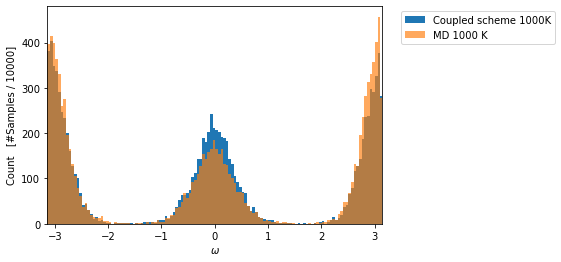

In [18]:
##CODE for Figure 19 of thesis

fig,ax = plt.subplots()

plot_omega_multiple(ax, 'coupled_pro_1000K_100psMD', 'pro_1000K_noconstr')

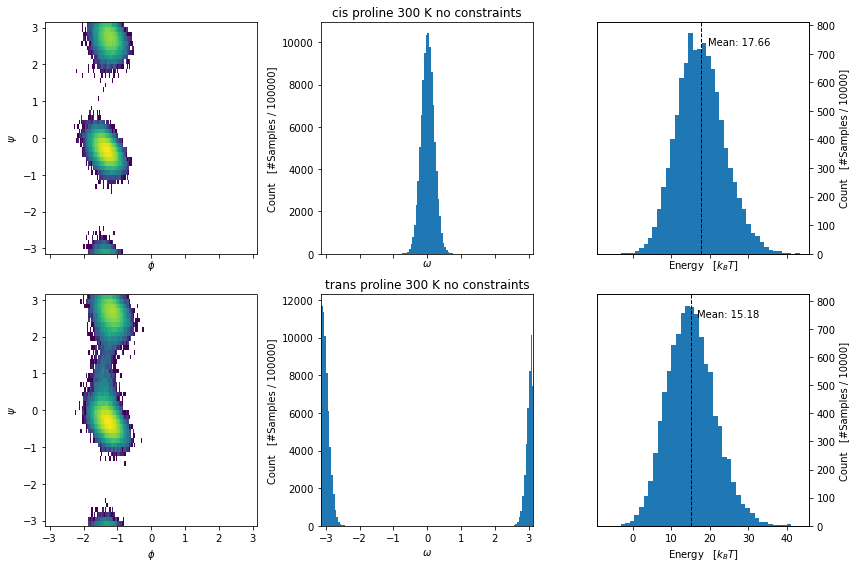

In [23]:
##CODE for Figure 16 of thesis

fig, axes = plt.subplots(2,3,figsize=(12,8), sharex='col')

plot_phi_psi(axes[0,0], cis_300K_noconstr_traj, fname='cis_pro_300K_noconstr_long', label='')
plot_omega(axes[0,1], cis_300K_noconstr_traj, 'cis proline 300 K no constraints')
plot_energy(axes[0,2], cis_300K_noconstr_traj, 'cis_pro_300K_noconstr_long')
plot_phi_psi(axes[1,0], trans_300K_noconstr_traj, fname='trans_pro_300K_noconstr_long', label='')
plot_omega(axes[1,1], trans_300K_noconstr_traj, 'trans proline 300 K no constraints')
plot_energy(axes[1,2], trans_300K_noconstr_traj, 'trans_pro_300K_noconstr_long')

plt.tight_layout()